## Word level Seq to Seq
Note that this encoder decoder model is a word level encoder decoder model

In [3]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

C:\Users\Rajdeep\AppData\Local\conda\conda\envs\tfdeeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [60]:
batch_size = 64 # declaring the batch size

In [61]:
epochs = 100 # number of epochs to train

In [62]:
latent_dim = 256

In [63]:
num_samples = 2000

In [64]:
import os, sys

In [65]:
data_path = os.path.join(os.path.dirname(os.getcwd()), "datasets", "fra-eng", "fra.txt") # path to the corpus file
# note that it is super important to know the format of the corpus file
# in this case the format is such
# <eng-text><tab><french-translation of the same eng text>
# each new training example is in a new line

In [66]:
input_texts = []
target_texts = []
# input_characters = set()
# target_characters = set()
input_words = set()
target_words = set()

In [68]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split("\n") # spliting training examples
    
lines = lines[:num_samples]
lines = lines[::-1]

# remember we are trying to get only `sample` number of lines and not any more for training 
for line in lines[:min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split("\t")
    
    target_text = '\t' + target_text + "\n"
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    # including chars in input and target characters
#     for char in input_text:
#         if char not in input_characters:
#             input_characters.add(char)
    
#     for char in target_text:
#         if char not in target_characters:
#             target_characters.add(char)
    for word in input_text.split(" "):
        if word not in input_words:
            input_words.add(word)
    #note that the target words need to contain the tab and newline as separate words
    for word in target_text.split(" "):
        word = word.replace("\t", "")
        word = word.replace("\t", "")
        if word not in target_words:    
            target_words.add(word)
    
input_words.add(".")

target_words.add("\n")
target_words.add("\t")

In [69]:
# here input_characters is the total number of input characters
# input_characters = sorted(list(input_characters))
# target_characters = sorted(list(target_characters))
input_words = sorted(list(input_words))
target_words = sorted(list(target_words))

# num_encoder_tokens = len(input_characters)
# num_decoder_tokens = len(target_characters)
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)


# max_encoder_seq_length = max([len(txt) for txt in input_texts])
# max_decoder_seq_length = max([len(txt) for txt in target_texts])
max_encoder_seq_length = max([len(txt.split(" ")) for txt in input_texts])
max_decoder_seq_length = max([len(txt.split(" ")) for txt in target_texts])

print("Number of samples: " + str(len(input_texts))) # total number of samples that we are training
print("Number of unique input tokens: " + str(num_encoder_tokens))
print("Number of unique output tokens: " + str(num_decoder_tokens))
print("Max sequence length for inputs: " + str(max_encoder_seq_length))
print("Max sequence length for outputs: " + str(max_decoder_seq_length))


Number of samples: 3998
Number of unique input tokens: 845
Number of unique output tokens: 1645
Max sequence length for inputs: 4
Max sequence length for outputs: 9


In [70]:
# note that here we are only taking the first 1000 training examples

In [71]:
# input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
input_token_index = dict([(word, i) for i, word in enumerate(input_words)])
# recall that input_characters is a list of all the unique input characters that we have in the 1000 training examples
# that we have read so far

# what enumerate does is that it assigns a counter to the unique characters, so basically if we get the following list
# a = ["ola", "mundo", "keras"], we would get back from enumerate 1, "ola"; 2, "mundo"; 3, "keras"

# target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
target_token_index = dict([(word, i) for i, word in enumerate(target_words)])

In [72]:
# here is the important part as we are defining what goes into the input data
# max_encoder seq length is the maximum number of characters in one training example in the entire corpus
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')

# the number of input_texts and the number of target_texts will be the same
decoder_input_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

# here we just created the vectors that we are going to use as inputs for the encoder and inputs and targets for the 
# decoder

In [73]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    input_text_words = input_text.split(" ") # the following 2 lines to be included for word level enc-dec
    target_text_words = target_text.split(" ")
    for t, word in enumerate(input_text_words):
        # i is the first index as it is the ith training example 
        # t is the second index as the t-th character in ith training example
        if "." in word and word[- 1] != ".": # patchy method of considering punctuations '.' and ',' as separate words
            period_split_words = word.split(".")
            encoder_input_data[i, t, input_token_index["."]] = 1
            encoder_input_data[i, t, input_token_index[period_split_words[1]]] = 1
        else:
            encoder_input_data[i, t, input_token_index[word]] = 1
            
    for t, word in enumerate(target_text_words):
        # here a tb splitting must be done in order to treat the tab as a separate word
        if "\t" in word:
            tab_split_words = word.split("\t")
            decoder_input_data[i, t, target_token_index["\t"]] = 1
            decoder_input_data[i, t, target_token_index[tab_split_words[1]]] = 1
        else:
            decoder_input_data[i, t, target_token_index[word]] = 1
        
        # Here is an important thing to understand
        ###############---------------------------IMPORTANT------------------------#####################
        # The decoder_target_data will be ahead of the decoder_input_data by one time step and this is an important factor
        # The decoder_target_data will obviously not contain the first character
        if t > 0:
            if "\t" in word:
                tab_split_words = word.split("\t")
                decoder_target_data[i, t-1, target_token_index["\t"]] = 1
                decoder_target_data[i, t-1, target_token_index[tab_split_words[1]]] = 1
            else:
                decoder_target_data[i, t - 1, target_token_index[word]] = 1
        

In [74]:
encoder_inputs = Input(shape=(None, num_encoder_tokens)) # num_encoder_tokens is essentially the vocab size

In [75]:
encoder = LSTM(latent_dim, return_state=True)
# Each unit or cell of LSTM within the layer has an internal cell state referred to as c and a hidden state referred
# to as h. 
# If we need to access the internal state c of the last time step we need to use return_state = True

In [76]:
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# here the encoder_outputs would be hidden state at last time step, state_h would be the hidden state of the last time step
# again and state_c is the internal state of the last time step

In [77]:
encoder_states = [state_h, state_c] # we will only keep the states and discard the output

In [78]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))

In [79]:
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# return sequences will return the hidden states for each and every time step

In [80]:
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# note here we are passing the encoder_states as the initial_state of the decoder lstm
# decoder_outputs will actially contain the hidden states of all the time steps as an array

In [81]:
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
# Dense is an ordinary dense neural network. 

In [82]:
decoder_outputs = decoder_dense(decoder_outputs)

In [83]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [84]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# passing all the data here

Train on 3198 samples, validate on 800 samples
Epoch 1/100
3198/3198 [==============================] - 48s 15ms/step - loss: 1.3698 - val_loss: 1.0196
Epoch 2/100
3198/3198 [==============================] - 52s 16ms/step - loss: 1.2137 - val_loss: 0.9631
Epoch 3/100
3198/3198 [==============================] - 45s 14ms/step - loss: 1.1446 - val_loss: 0.9062
Epoch 4/100
3198/3198 [==============================] - 42s 13ms/step - loss: 1.0699 - val_loss: 0.8699
Epoch 5/100
3198/3198 [==============================] - 42s 13ms/step - loss: 0.9927 - val_loss: 0.8074
Epoch 6/100
3198/3198 [==============================] - 42s 13ms/step - loss: 0.9219 - val_loss: 0.7677
Epoch 7/100
3198/3198 [==============================] - 42s 13ms/step - loss: 0.8602 - val_loss: 0.7289
Epoch 8/100
3198/3198 [==============================] - 43s 13ms/step - loss: 0.8013 - val_loss: 0.6945
Epoch 9/100
3198/3198 [==============================] - 48s 15ms/step - loss: 0.7488 - val_loss: 0.6693
Epoch 10

Epoch 78/100
3198/3198 [==============================] - 53s 17ms/step - loss: 0.0649 - val_loss: 0.0532
Epoch 79/100
3198/3198 [==============================] - 54s 17ms/step - loss: 0.0649 - val_loss: 0.0527
Epoch 80/100
3198/3198 [==============================] - 56s 18ms/step - loss: 0.0644 - val_loss: 0.0525
Epoch 81/100
3198/3198 [==============================] - 53s 17ms/step - loss: 0.0640 - val_loss: 0.0519
Epoch 82/100
3198/3198 [==============================] - 53s 16ms/step - loss: 0.0639 - val_loss: 0.0530
Epoch 83/100
3198/3198 [==============================] - 53s 17ms/step - loss: 0.0637 - val_loss: 0.0519
Epoch 84/100
3198/3198 [==============================] - 52s 16ms/step - loss: 0.0634 - val_loss: 0.0515
Epoch 85/100
3198/3198 [==============================] - 51s 16ms/step - loss: 0.0636 - val_loss: 0.0503
Epoch 86/100
3198/3198 [==============================] - 54s 17ms/step - loss: 0.0625 - val_loss: 0.0507
Epoch 87/100
3198/3198 [======================

In [46]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'loss'])


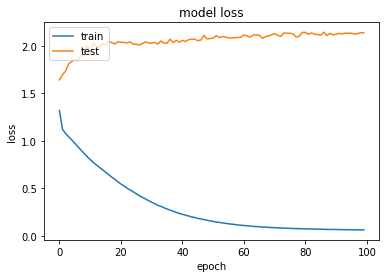

In [49]:
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
model.save('s2s2000SamplesWordLevel-Update30-4-18-11-14am.h5')

C:\Users\Rajdeep\AppData\Local\conda\conda\envs\tfdeeplearning\lib\site-packages\keras\engine\topology.py:2379: UserWarning: Layer lstm_3 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_2/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_2/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [157]:
# Inference Model (Sampling sequences)
# For sampling the sequences here is the strategy to be followed

# 1. Encode the input and retrieve the initial encoder state
# 2. Run one step of the decoder with its initial encoder state and a "start of sequence" token as target
# 3. Output will be the next target token and current states

In [158]:
# In the original keras example, they are using the training examples themselves to predict the french statements
# However we would like to use predict new statements
# For this we would have to change a few things in order to achieve what we need to achieve

In [171]:
# preparing the test data
test_data_path = os.path.join(os.path.dirname(os.getcwd()), "datasets", "fra-eng", "fra-test.txt") # path to the test 
# corpus file
test_input_texts = []
with open(test_data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split("\n") # spliting training examples

# remember we are trying to get only `sample` number of lines and not any more for training 
for line in lines:
    input_text = line
    
#     target_text = '\t' + target_text + "\n"
    
    test_input_texts.append(input_text)
#     target_texts.append(target_text)
    
encoder_test_input_data = np.zeros((len(test_input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')

for i, (test_input_text) in enumerate(test_input_texts):
    print("i now:" + str(i))
    test_input_text = test_input_text.split(" ")
    for t, word in enumerate(test_input_text):
        # i is the first index as it is the ith training example 
        # t is the second index as the t-th character in ith training example
#         print("t, char now: " + str(t) + ", " + str(char))
    
        if "." in word: # patchy method of considering punctuations '.' and ',' as separate words
            period_split_words = word.split(".")
            encoder_test_input_data[i, t, input_token_index["."]] = 1
            encoder_test_input_data[i, t, input_token_index[period_split_words[1]]] = 1
        else:
            encoder_test_input_data[i, t, input_token_index[word]] = 1

i now:0
i now:1


In [172]:
encoder_model = Model(encoder_inputs, encoder_states)

In [173]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

In [174]:
# reverse_input_char_index = dict(
#     (i, char) for char, i in input_token_index.items())
# reverse_target_char_index = dict(
#     (i, char) for char, i in target_token_index.items())
reverse_input_word_index = dict(
    (i, word) for word, i in input_token_index.items())
reverse_target_word_index = dict(
    (i, word) for word, i in target_token_index.items())

In [175]:
def decode_sequence(input_seq):
    """
    This function is for decoding a sequence of english letters
    """
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq) # this is actually encoder_input data

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.
    
    # target_sequence is simply a one hot vector of size vocab size

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # predicting one character at a time
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_token_index]
        decoded_sentence += " " + sampled_word

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [176]:
for seq_index in range(2):
    # this trick below is just for converting input_seq to a list
    input_seq = encoder_test_input_data[seq_index: seq_index + 1] # we will need to form a new encoder_input_data
    decoded_sentence = decode_sequence(input_seq=input_seq)
    print('-')
    print("Input sentence: ", test_input_texts[seq_index])
    print("Decoded sentence: ", decoded_sentence)
    

-
Input sentence:  No Cheers!
Decoded sentence:   n'en !

-
Input sentence:  Jump. on.
Decoded sentence:   à rouler
